Rui Wang 1007791695

# Homework #3 -- *you'll need to do this on google colab*

0. Find data set on [kaggle](https://www.kaggle.com).
1. Provide posterior inference for a column of data with a `PyMC` ***normal-gamma specification***.
2. Find a different column of data for which a ***normal-gamma specification*** isn't justified.
3. Create a different `PyMC` specification that IS appropriate for this new data column:
    - here are your `PyMC` choices for [continuous distributions](https://www.pymc.io/projects/docs/en/stable/api/distributions/continuous.html)
    - here are your `PyMC` choices for [discrete distributions](https://www.pymc.io/projects/docs/en/stable/api/distributions/discrete.html)

### ...just make sure you've chosen a reasonable likelihood for your non-normal data and that the support of your priors makes sense for the values the parameters of your likelihood can take on...

4. Provide posterior inference for the parameters of your new specification given the column of non-normal data
using `PyMC` and provide an analysis of the MCMC chains.

# Part 0 #

I have found this dataset about Clothes Price Prediction in Kaggle, and here is the link to the dataset: https://www.kaggle.com/datasets/teertha/ushealthinsurancedataset

This dataset contains 1338 rows of insured data, where the Insurance charges are given against the following attributes of the insured: Age, Sex, BMI, Number of Children, Smoker and Region. The attributes are a mix of numeric and categorical variables.


In [87]:
import random
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import requests

df = pd.read_csv("insurance.csv")

df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


From the above table of all varianles, we can see that we got 4 numerical variables and the sample size is 1338. The BMI is an important factor to relate the health insurance.

With this dataset, we can construct models that association between age, BMI, the number of children and charge for health insurance.

# Part 1#
we use a histogram to examine BMI's distribution.

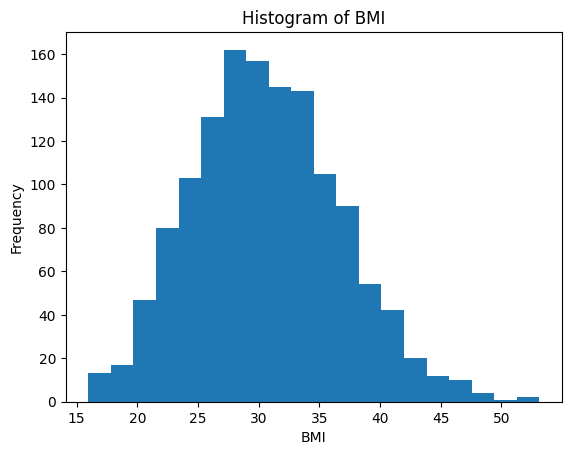

In [88]:
plt.hist(df["bmi"], bins = 20)
plt.xlabel("BMI")
plt.ylabel("Frequency")
plt.title("Histogram of BMI")
plt.show()

For Posterior with normal-gamma.

which specifies...

\begin{align*}
p(\theta,\phi|x) &\propto{} p(\theta,\phi,x) = \overset{N(\theta, \phi)}{p(x|\theta)}\overset{N(\theta_0, \tau)}{p(\theta)}\overset{\text{Gamma}(\alpha,\beta)}{p(\phi)\quad\quad}  (\theta \perp\!\!\perp \phi) \leftarrow \text{priors} \\
&={}  \left[\prod_{i=1}^n\sqrt{\frac{\phi}{2\pi}} e^{-\frac{\phi\left(x_i-\theta\right)^2}{2}}\right] \sqrt{\frac{\tau}{2\pi}} e^{-\frac{\tau\left(\theta-\theta_0\right)^2}{2}} \frac{\beta ^{\alpha}}{\Gamma(\alpha)} \phi^{\alpha -1}e^{-\beta \phi}\\
\end{align*}

Normal-Gamma Distribution for BMI

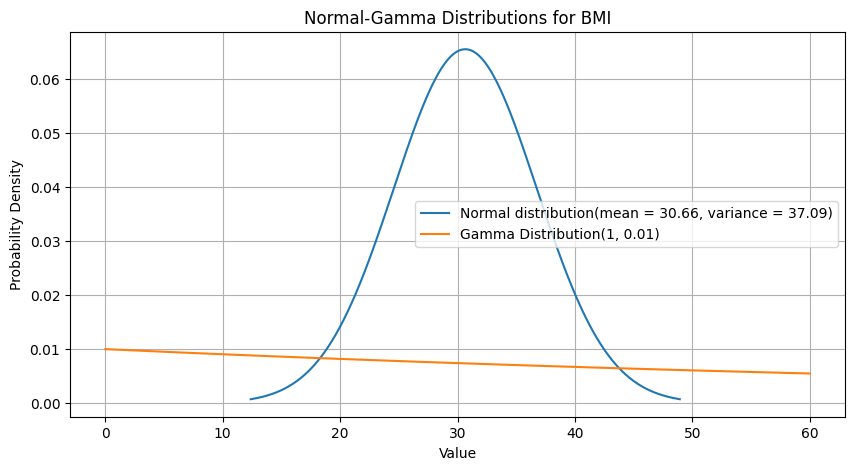

In [89]:
alpha, beta = 1, 0.01
theta_0 = 30.66
sigma = 6.09
tau = 1/(sigma*sigma)

x_normal = np.linspace(theta_0 - 3*sigma, theta_0 + 3*sigma, 1338)
x_gamma = np.linspace(0,60,1338)

pdf_normal = stats.norm.pdf(x_normal, theta_0, 1/tau**0.5)
pdf_gamma = stats.gamma.pdf(x_gamma, alpha, scale = 1/beta)

plt.figure(figsize = (10, 5))
plt.plot(x_normal, pdf_normal, label = "Normal distribution(mean = 30.66, variance = 37.09)")
plt.plot(x_gamma, pdf_gamma, label = "Gamma Distribution(1, 0.01)")
plt.title("Normal-Gamma Distributions for BMI")
plt.xlabel("Value")
plt.ylabel("Probability Density")
plt.legend()
plt.grid()
plt.show()

With the above distributions and hyperparameters specified, we can conduct our posterior inference using PyMC.

In [90]:
alpha, beta = 1, 0.01
theta_0 = 30.66
sigma = 6.09
tau = 1/(sigma*sigma)

import pymc as pm
normal_gamma_BMI_model = pm.Model()
with normal_gamma_BMI_model:
    theta = pm.Normal("theta", mu=30.66, sigma=6.09)
    phi = pm.Gamma("phi", alpha=alpha, beta=beta)
    x_obs = pm.Normal("likelihood", mu=theta, sigma=1/phi**0.5, observed = df["bmi"])

In [91]:
random.seed(1007791695)
with normal_gamma_BMI_model:
    idata_HMC = pm.sample()

with normal_gamma_BMI_model:
    MH = pm.Metropolis([theta, phi], S=np.array([0.1]), tune=False, tune_interval=0)
    idata_MH = pm.sample(step=MH)

/usr/local/lib/python3.10/dist-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


HMC Split-Rhats {'theta': 1.0016, 'phi': 1.0008}


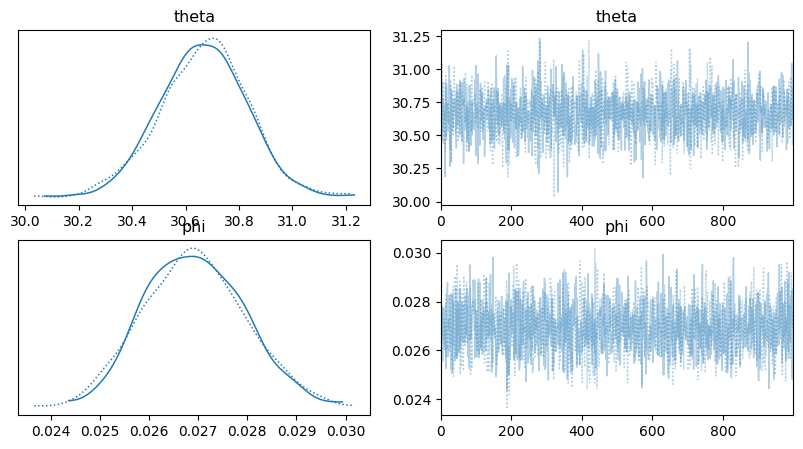

In [92]:
import arviz as az
fig, ax = plt.subplots(2,2, figsize = (10,5))
az.plot_trace(idata_HMC,axes = ax [:2, :2])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()})

In [93]:
idata_HMC.posterior["phi"].values.flatten().shape[-1]
az.summary(idata_HMC, round_to = 2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,30.67,0.16,30.33,30.94,0.0,0.0,2308.86,1448.31,1.0
phi,0.03,0.00,0.03,0.03,0.0,0.0,2143.64,1551.07,1.0


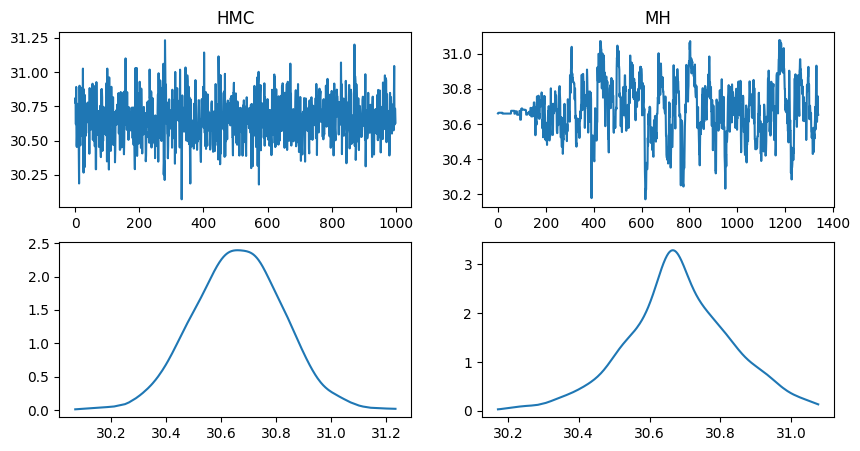

In [94]:
from scipy.stats import gaussian_kde; import matplotlib.pyplot as plt; fig,ax = plt.subplots(2,2, figsize=(10,5))
n_mcmc_samples = 1338
mcmc_chain = idata_HMC.posterior["theta"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values; mcmc_chain_sorted = sorted(mcmc_chain)
ax[0,0].plot(mcmc_chain); ax[1,0].plot(mcmc_chain_sorted,gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted)); ax[0,0].set_title("HMC");
mcmc_chain = idata_MH.posterior["theta"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values; mcmc_chain_sorted = sorted(mcmc_chain)
ax[0,1].plot(mcmc_chain); ax[1,1].plot(mcmc_chain_sorted,gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted)); ax[0,1].set_title("MH");

#Part4(i)#
For BMI(Normal-gamma distribution Variable)

number of MCMC samples: 2000
number of MCMC samples: 4000


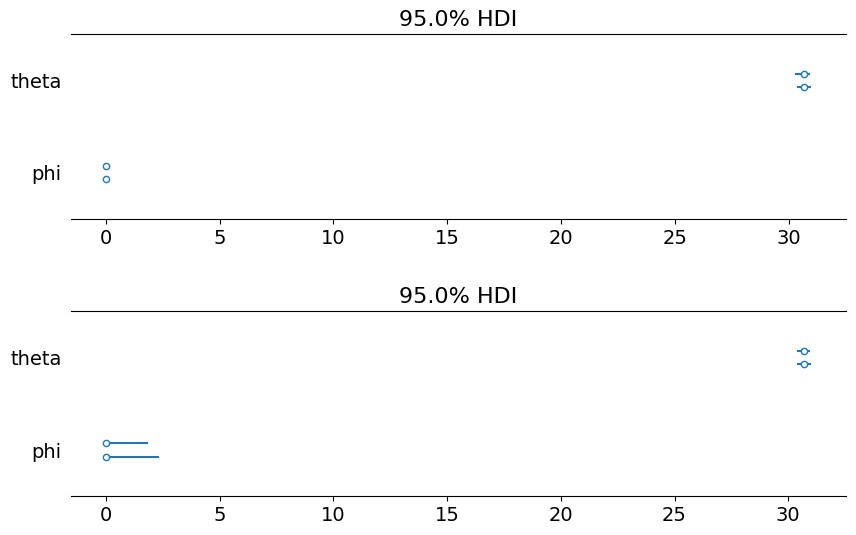

In [95]:
import arviz as az; print("number of MCMC samples:", idata_HMC.posterior['phi'].values.flatten().shape[-1])
az.summary(idata_HMC, round_to=2)

print("number of MCMC samples:", idata_MH.posterior['phi'].values.flatten().shape[-1])
az.summary(idata_MH, round_to=2)

import arviz as az; import matplotlib.pyplot as plt; fig,ax = plt.subplots(2,1, figsize=(10,6))
plt.subplots_adjust(hspace = 0.5)
az.plot_forest(idata_HMC, var_names=["theta","phi"], combined=False, hdi_prob=0.95, ax=ax[0]);
az.plot_forest(idata_MH, var_names=["theta","phi"], combined=False, hdi_prob=0.95, ax=ax[1]);

#Part 2#
Variable is not normal distribution.\
Normal-Gamma is not justified.

we use a histogram to examine Age's distribution.

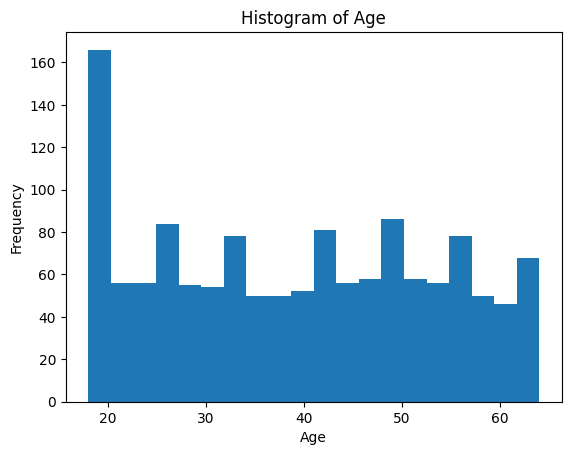

In [62]:
plt.hist(df["age"], bins = 20)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Histogram of Age")
plt.show()

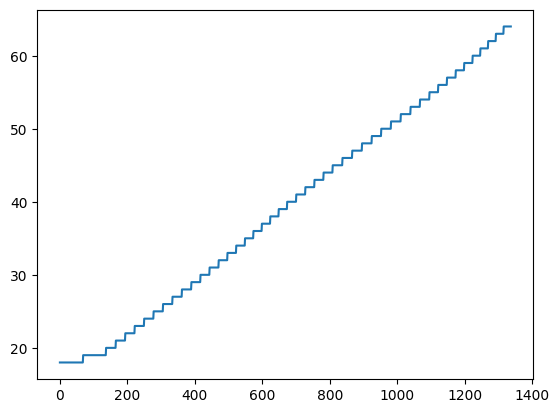

In [68]:
plt.plot(df["age"].sort_values().values)

We may use uniform likelihood to examine age. The histogram of age is kind of uniform distribution model. It cannot be justified by Normal-Gamma specification.

# Part 3#

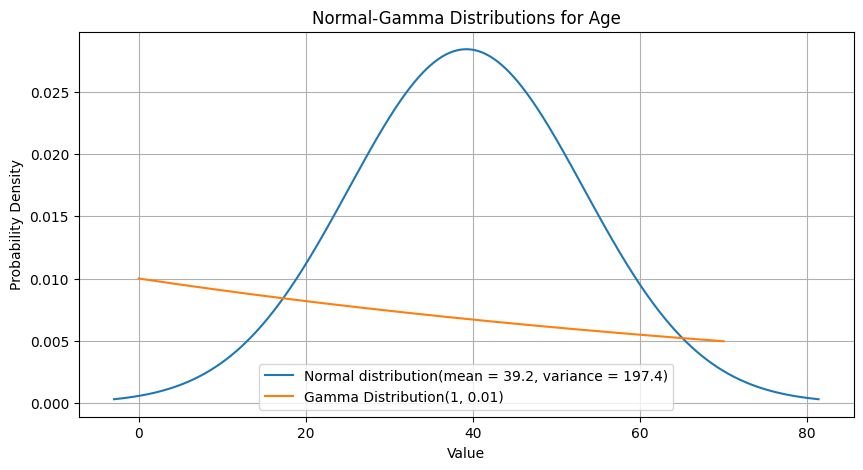

In [74]:
alpha, beta = 1, 0.01
theta_0 = 39.2
sigma = 14.05
tau = 1/(sigma*sigma)

x_normal = np.linspace(theta_0 - 3*sigma, theta_0 + 3*sigma, 1338)
x_gamma = np.linspace(0,70,1338)

pdf_normal = stats.norm.pdf(x_normal, theta_0, 1/tau**0.5)
pdf_gamma = stats.gamma.pdf(x_gamma, alpha, scale = 1/beta)

plt.figure(figsize = (10, 5))
plt.plot(x_normal, pdf_normal, label = "Normal distribution(mean = 39.2, variance = 197.4)")
plt.plot(x_gamma, pdf_gamma, label = "Gamma Distribution(1, 0.01)")
plt.title("Normal-Gamma Distributions for Age")
plt.xlabel("Value")
plt.ylabel("Probability Density")
plt.legend()
plt.grid()
plt.show()

In [75]:
alpha, beta = 1, 0.01
theta_0 = 39.2
sigma = 14.05
tau = 1/(sigma*sigma)

import pymc as pm
normal_gamma_Age_model = pm.Model()
with normal_gamma_Age_model:
    theta = pm.Normal("theta", mu=39.2, sigma=14.05)
    phi = pm.Gamma("phi", alpha=alpha, beta=beta)
    x_obs = pm.Normal("likelihood", mu=theta, sigma=1/phi**0.5, observed = df["age"])

random.seed(1007791695)
with normal_gamma_Age_model:
    idata_HMC = pm.sample()

with normal_gamma_Age_model:
    MH = pm.Metropolis([theta, phi], S=np.array([0.1]), tune=False, tune_interval=0)
    idata_MH = pm.sample(step=MH)

/usr/local/lib/python3.10/dist-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


HMC Split-Rhats {'theta': 1.0033, 'phi': 1.0013}


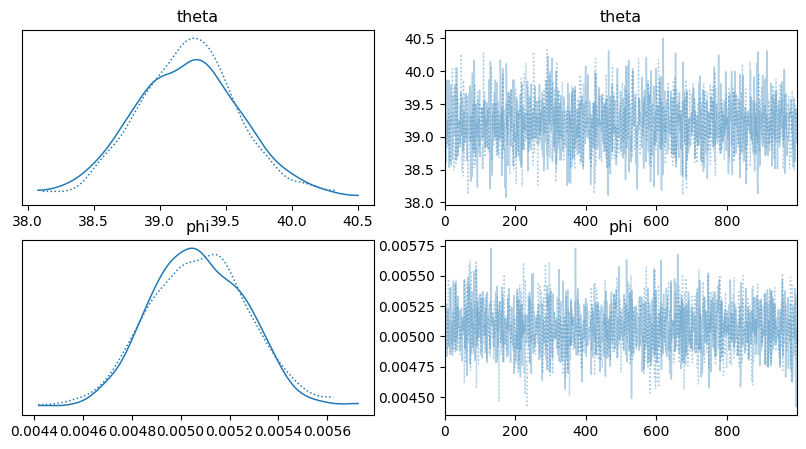

In [76]:
import arviz as az
fig, ax = plt.subplots(2,2, figsize = (10,5))
az.plot_trace(idata_HMC,axes = ax [:2, :2])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()})

In [86]:
idata_HMC.posterior["phi"].values.flatten().shape[-1]
az.summary(idata_HMC, round_to = 2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,39.21,0.39,38.47,39.94,0.01,0.01,2162.45,1527.13,1.0
phi,0.01,0.00,0.00,0.01,0.00,0.00,1962.62,1313.38,1.0


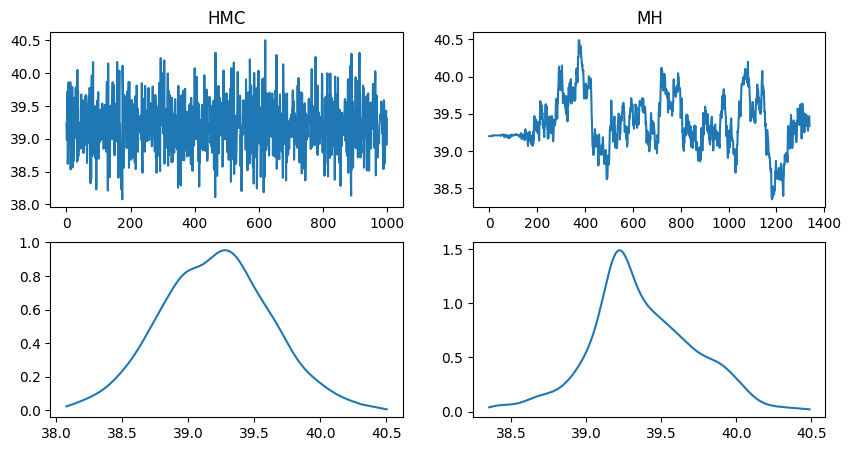

In [78]:
from scipy.stats import gaussian_kde; import matplotlib.pyplot as plt; fig,ax = plt.subplots(2,2, figsize=(10,5))
n_mcmc_samples = 1338
mcmc_chain = idata_HMC.posterior["theta"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values; mcmc_chain_sorted = sorted(mcmc_chain)
ax[0,0].plot(mcmc_chain); ax[1,0].plot(mcmc_chain_sorted,gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted)); ax[0,0].set_title("HMC");
mcmc_chain = idata_MH.posterior["theta"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values; mcmc_chain_sorted = sorted(mcmc_chain)
ax[0,1].plot(mcmc_chain); ax[1,1].plot(mcmc_chain_sorted,gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted)); ax[0,1].set_title("MH");

#Part 4(ii)#
For Age(Non-normal-gamma distribution Variable)

number of MCMC samples: 2000
number of MCMC samples: 4000


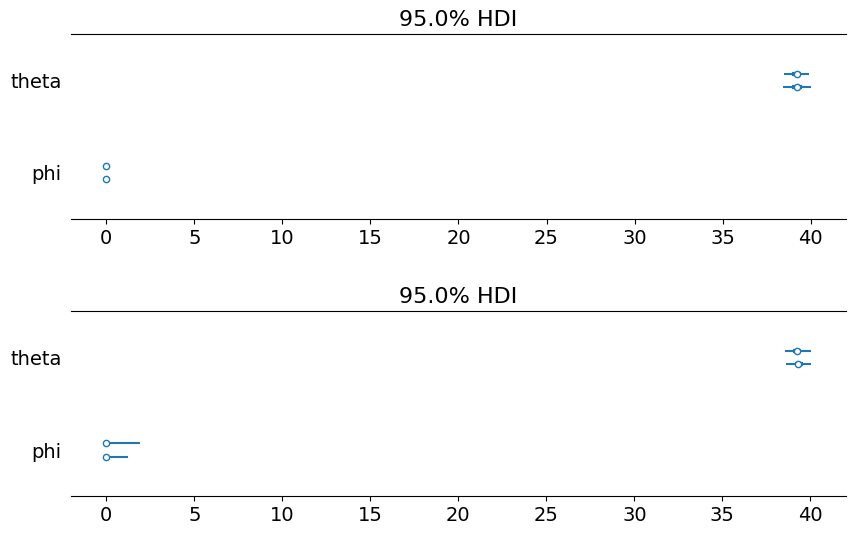

In [80]:
import arviz as az; print("number of MCMC samples:", idata_HMC.posterior['phi'].values.flatten().shape[-1])
az.summary(idata_HMC, round_to=2)

print("number of MCMC samples:", idata_MH.posterior['phi'].values.flatten().shape[-1])
az.summary(idata_MH, round_to=2)

import arviz as az; import matplotlib.pyplot as plt; fig,ax = plt.subplots(2,1, figsize=(10,6))
plt.subplots_adjust(hspace = 0.5)
az.plot_forest(idata_HMC, var_names=["theta","phi"], combined=False, hdi_prob=0.95, ax=ax[0]);
az.plot_forest(idata_MH, var_names=["theta","phi"], combined=False, hdi_prob=0.95, ax=ax[1]);